## Abstractive Text Summarization using Seq2Seq LSTM for Amazon Review Dataset.

import numpy as np
import pandas as pd 
import re
from bs4 import BeautifulSoup
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import nltk
nltk.download('stopwords')  
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

##Read the dataset

This dataset consists of reviews of fine foods from Amazon. Download the dataset from kaggle.

https://www.kaggle.com/code/currie32/summarizing-text-with-amazon-reviews/notebook

In [4]:
data=pd.read_csv("Reviews.csv",nrows=100000)

### Preprocessing
Data cleaning is an important part of the text summarization. Using unclean data may result into the disastrous results.

In [5]:
data.drop_duplicates(subset=['Text'],inplace=True)
data.dropna(axis=0,inplace=True)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 88421 entries, 0 to 99999
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Id                      88421 non-null  int64 
 1   ProductId               88421 non-null  object
 2   UserId                  88421 non-null  object
 3   ProfileName             88421 non-null  object
 4   HelpfulnessNumerator    88421 non-null  int64 
 5   HelpfulnessDenominator  88421 non-null  int64 
 6   Score                   88421 non-null  int64 
 7   Time                    88421 non-null  int64 
 8   Summary                 88421 non-null  object
 9   Text                    88421 non-null  object
dtypes: int64(5), object(5)
memory usage: 7.4+ MB


the dictionary for expanding the contractions

In [7]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

### Removing stop words

In [8]:
stop_words = set(stopwords.words('english')) 

def text_cleaner(text,num):
    newString = text.lower()
    newString = BeautifulSoup(newString, "lxml").text
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString) 
    newString = re.sub('[m]{2,}', 'mm', newString)
    if(num==0):
        tokens = [w for w in newString.split() if not w in stop_words]
    else:
        tokens=newString.split()
    long_words=[]
    for i in tokens:
        if len(i)>1:                                                 #removing short word
            long_words.append(i)   
    return (" ".join(long_words)).strip()

In [9]:
#call the function
cleaned_text = []
for t in data['Text']:
    cleaned_text.append(text_cleaner(t,0)) 

In [10]:
cleaned_text[:5]  

['bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better',
 'product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo',
 'confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar story lewis lion witch wardrobe treat seduces edmund selling brother sisters witch',
 'looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal',
 'great taffy great price wide assortment yummy taffy delivery quick taffy lover deal']

In [11]:
#call the function
cleaned_summary = []
for t in data['Summary']:
    cleaned_summary.append(text_cleaner(t,1))

In [12]:
cleaned_summary[:10]

['good quality dog food',
 'not as advertised',
 'delight says it all',
 'cough medicine',
 'great taffy',
 'nice taffy',
 'great just as good as the expensive brands',
 'wonderful tasty taffy',
 'yay barley',
 'healthy dog food']

In [13]:
data['cleaned_text']=cleaned_text
data['cleaned_summary']=cleaned_summary

In [14]:
data.replace('', np.nan, inplace=True)
data.dropna(axis=0,inplace=True)

Analyzing the distribution of the sequences.
Look at the length of the reviews and the summary to get an overall idea about the distribution of length of the text to fix the maximum length of the sequence to be generated.

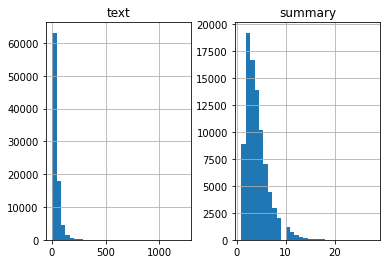

In [15]:
import matplotlib.pyplot as plt

text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in data['cleaned_text']:
      text_word_count.append(len(i.split()))

for i in data['cleaned_summary']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})

length_df.hist(bins = 30)
plt.show()

In [16]:
cnt=0
for i in data['cleaned_summary']:
    if(len(i.split())<=8):
        cnt=cnt+1
print(cnt/len(data['cleaned_summary']))

0.9424907471335922


In [17]:
max_text_len=30
max_summary_len=8

In [18]:
cleaned_text =np.array(data['cleaned_text'])
cleaned_summary=np.array(data['cleaned_summary'])

short_text=[]
short_summary=[]

for i in range(len(cleaned_text)):
    if(len(cleaned_summary[i].split())<=max_summary_len and len(cleaned_text[i].split())<=max_text_len):
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])
        
df=pd.DataFrame({'text':short_text,'summary':short_summary})

Add the START and END special tokens at the beginning and end of the summary

In [19]:
df['summary'] = df['summary'].apply(lambda x : 'sostok '+ x + ' eostok')

Dividing the test and the train data

In [20]:
from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(np.array(df['text']),np.array(df['summary']),test_size=0.1,random_state=0,shuffle=True) 

Preparing the tokenizer, A tokenizer builds the vocabulary and converts a word sequence to an integer sequence.
Reviews Tokenizer code is in below cell

In [21]:
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences

#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(list(x_tr))

In [ ]:
Rarewords and its Coverage

In [22]:
thresh=4

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in x_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 66.12339930151339
Total Coverage of rare words: 2.953684513790566


tot_cnt gives the size of vocabulary (which means every unique words in the text)
cnt gives me the no. of rare words whose count falls below threshold
tot_cnt - cnt gives me the top most common words

Let us define the tokenizer with top most common words for reviews

In [23]:
#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences
x_tr_seq    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val_seq   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val   =   pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

#size of vocabulary ( +1 for padding token)
x_voc   =  x_tokenizer.num_words + 1

In [24]:
x_voc

8440

we will do the tokenization for summary as well

In [25]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer()   
y_tokenizer.fit_on_texts(list(y_tr))

Rarewords and its Coverage

In [26]:
thresh=6

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 78.12740675541863
Total Coverage of rare words: 5.3921899389571895


Define the tokenizer with top most common words for summary.

In [27]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
y_tokenizer.fit_on_texts(list(y_tr))

#convert text sequences into integer sequences
y_tr_seq    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val_seq   =   y_tokenizer.texts_to_sequences(y_val) 

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')

#size of vocabulary
y_voc  =   y_tokenizer.num_words +1

In [28]:
y_tokenizer.word_counts['sostok'],len(y_tr)   

(42453, 42453)

Deleting the rows that contain only START and END tokens

In [29]:
ind=[]
for i in range(len(y_tr)):
    cnt=0
    for j in y_tr[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_tr=np.delete(y_tr,ind, axis=0)
x_tr=np.delete(x_tr,ind, axis=0)

In [30]:
ind=[]
for i in range(len(y_val)):
    cnt=0
    for j in y_val[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_val=np.delete(y_val,ind, axis=0)
x_val=np.delete(x_val,ind, axis=0)

### Model
Return Sequences = True: When the return sequences parameter is set to True, LSTM produces the hidden state and cell state for every timestep

Return State = True: When return state = True, LSTM produces the hidden state and cell state of the last timestep only

Initial State: This is used to initialize the internal states of the LSTM for the first timestep

Stacked LSTM: Stacked LSTM has multiple layers of LSTM stacked on top of each other. This leads to a better representation of the sequence. 

 Building a 3 stacked LSTM for the encoder:

In [32]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, \
    Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

In [33]:
latent_dim = 300
embedding_dim = 200

# Encoder
encoder_inputs = Input(shape=(max_text_len, ))

# Embedding layer
enc_emb = Embedding(x_voc, embedding_dim,
                    trainable=True)(encoder_inputs)

# Encoder LSTM 1
encoder_lstm1 = LSTM(latent_dim, return_sequences=True,
                     return_state=True, dropout=0.4,
                     recurrent_dropout=0.4)
(encoder_output1, state_h1, state_c1) = encoder_lstm1(enc_emb)

# Encoder LSTM 2
encoder_lstm2 = LSTM(latent_dim, return_sequences=True,
                     return_state=True, dropout=0.4,
                     recurrent_dropout=0.4)
(encoder_output2, state_h2, state_c2) = encoder_lstm2(encoder_output1)

# Encoder LSTM 3
encoder_lstm3 = LSTM(latent_dim, return_state=True,
                     return_sequences=True, dropout=0.4,
                     recurrent_dropout=0.4)
(encoder_outputs, state_h, state_c) = encoder_lstm3(encoder_output2)

# Set up the decoder, using encoder_states as the initial state
decoder_inputs = Input(shape=(None, ))

# Embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim, trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

# Decoder LSTM
decoder_lstm = LSTM(latent_dim, return_sequences=True,
                    return_state=True, dropout=0.4,
                    recurrent_dropout=0.2)
(decoder_outputs, decoder_fwd_state, decoder_back_state) = \
    decoder_lstm(dec_emb, initial_state=[state_h, state_c])

# Dense layer
decoder_dense = TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 30)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 30, 200)      1688000     ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 30, 300),    601200      ['embedding[0][0]']              
                                 (None, 300),                                                     
                                 (None, 300)]                                                     
                                                                                              

In [34]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)

#### Training the Model

In [35]:
history = model.fit(
    [x_tr, y_tr[:, :-1]],
    y_tr.reshape(y_tr.shape[0], y_tr.shape[1], 1)[:, 1:],
    epochs=16,
    callbacks=[es],
    batch_size=128,
    validation_data=([x_val, y_val[:, :-1]],
                     y_val.reshape(y_val.shape[0], y_val.shape[1], 1)[:
                     , 1:]),
    )

Epoch 1/50
324/324 [==============================] - 687s 2s/step - loss: 2.8036 - val_loss: 2.5546
Epoch 2/50
324/324 [==============================] - 669s 2s/step - loss: 2.4776 - val_loss: 2.4398
Epoch 3/50
324/324 [==============================] - 667s 2s/step - loss: 2.3405 - val_loss: 2.3268
Epoch 4/50
324/324 [==============================] - 649s 2s/step - loss: 2.2533 - val_loss: 2.2435
Epoch 5/50
324/324 [==============================] - 650s 2s/step - loss: 2.1732 - val_loss: 2.1887
Epoch 6/50
324/324 [==============================] - 655s 2s/step - loss: 2.1104 - val_loss: 2.1462
Epoch 7/50
324/324 [==============================] - 655s 2s/step - loss: 2.0584 - val_loss: 2.1188
Epoch 8/50
324/324 [==============================] - 657s 2s/step - loss: 2.0129 - val_loss: 2.0979
Epoch 9/50
324/324 [==============================] - 657s 2s/step - loss: 1.9718 - val_loss: 2.0706
Epoch 10/50
324/324 [==============================] - 660s 2s/step - loss: 1.9331 - val_lo

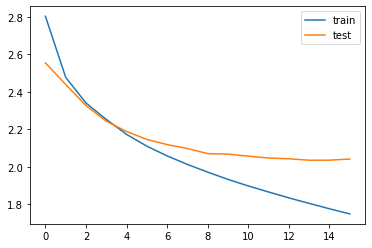

In [36]:
from matplotlib import pyplot

pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [37]:
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

### Inference
After training, the model is tested on new source sequences for which the target sequence is unknown. So, we set up the inference architecture to decode a test sequence.

In [38]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs,
                      state_h, state_c])

# Decoder setup

# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim, ))
decoder_state_input_c = Input(shape=(latent_dim, ))
decoder_hidden_state_input = Input(shape=(max_text_len, latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2 = dec_emb_layer(decoder_inputs)

# To predict the next word in the sequence, set the initial states to the states from the previous time step
(decoder_outputs2, state_h2, state_c2) = decoder_lstm(dec_emb2,
        initial_state=[decoder_state_input_h, decoder_state_input_c])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_outputs2)

# Final decoder model
decoder_model = Model([decoder_inputs] + [decoder_hidden_state_input,
                      decoder_state_input_h, decoder_state_input_c],
                      [decoder_outputs2] + [state_h2, state_c2])

In [39]:
def decode_sequence(input_seq):

    # Encode the input as state vectors.
    (e_out, e_h, e_c) = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1
    target_seq = np.zeros((1, 1))

    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''

    while not stop_condition:
        (output_tokens, h, c) = decoder_model.predict([target_seq]
                + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]

        if sampled_token != 'eostok':
            decoded_sentence += ' ' + sampled_token

        # Exit condition: either hit max length or find the stop word.
        if sampled_token == 'eostok' or len(decoded_sentence.split()) \
            >= max_summary_len - 1:
            stop_condition = True

        # Update the target sequence (of length 1)
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        (e_h, e_c) = (h, c)

    return decoded_sentence

Below are the functions to convert an integer sequence to a word sequence for summary as well as the reviews

In [40]:
# To convert sequence to summary
def seq2summary(input_seq):
    newString = ''
    for i in input_seq:
        if i != 0 and i != target_word_index['sostok'] and i \
            != target_word_index['eostok']:
            newString = newString + reverse_target_word_index[i] + ' '

    return newString


# To convert sequence to text
def seq2text(input_seq):
    newString = ''
    for i in input_seq:
        if i != 0:
            newString = newString + reverse_source_word_index[i] + ' '

    return newString

### Printing few summaries

In [42]:
for i in range(0,200):
    print("Review:",seq2text(x_tr[i]))
    print("Original summary:",seq2summary(y_tr[i]))
    print("Predicted summary:",decode_sequence(x_tr[i].reshape(1,max_text_len)))
    print("\n")

Review: gave caffeine shakes heart anxiety attack plus tastes unbelievably bad stick coffee tea soda thanks 
Original summary: hour 
Predicted summary:  not for me


Review: got great course good belgian chocolates better 
Original summary: would like to give it stars but 
Predicted summary:  great


Review: one best flavored coffees tried usually like flavored coffees one great serve company love 
Original summary: delicious 
Predicted summary:  great coffee


Review: salt separate area pain makes hard regulate salt putting like salt go ahead get product 
Original summary: tastes ok packaging 
Predicted summary:  not too salty


Review: really like product super easy order online delivered much cheaper buying gas station stocking good long drives 
Original summary: turkey jerky is great 
Predicted summary:  great taste


Review: best salad dressing delivered promptly quantities last vidalia onion dressing compares made oak hill farms sometimes find costco order front door want even or

In [6]:
def calc_rouge_scores(pred_summaries, gold_summaries, 
                                 keys=['rouge1', 'rougeL'], use_stemmer=True):
    #Calculate rouge scores
    scorer = rouge_scorer.RougeScorer(keys, use_stemmer= use_stemmer)
    
    n = len(pred_summaries)
    
    scores = [scorer.score(pred_summaries[j], gold_summaries[j]) for 
              j in range(n)] 
    
    dict_scores={}                                                            
    for key in keys:
        dict_scores.update({key: {}})
        
    
    for key in keys:
        
        precision_list = [scores[j][key][0] for j in range(len(scores))]
        recall_list = [scores[j][key][1] for j in range(len(scores))]
        f1_list = [scores[j][key][2] for j in range(len(scores))]

        precision = np.mean(precision_list)
        recall = np.mean(recall_list)
        f1 = np.mean(f1_list)
        
        dict_results = {'recall': recall, 'precision': precision, 'f1': f1}
        
        dict_scores[key] = dict_results
        
    return dict_scores

In [ ]:
scores = calc_rouge_scores(pred_summaries, gold_summaries, 
                                  keys=['rouge1', 'rougeL'], use_stemmer=True)
print(scores)

In [73]:
def summary_save(val):
 data1=[]
 data2=[]
 for i in range(0,val):
  data=[]
  data_p=[]
  s=seq2summary(y_tr[i])
  p=decode_sequence(x_tr[i].reshape(1,max_text_len))
  data.append(s) 
  data_p.append(p)
  data1.append(data)
  data2.append(data_p)
 return data1,data2 

In [77]:
data1, data2 = summary_save(200)

In [78]:
import csv  

header = ['original_summary']
header1=['predicted_summary']

with open('original.csv', 'w', encoding='UTF8') as f:
    writer = csv.writer(f)

    # write the header
    writer.writerow(header)

    # write the data
    writer.writerows(data1)



with open('predicted.csv', 'w', encoding='UTF8') as f:
    writer = csv.writer(f)

    # write the header
    writer.writerow(header1)

    # write the data
    writer.writerows(data2)    

In [55]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [8]:
from rouge_score import rouge_scorer

In [3]:
predicted_amazon_lstm_df=pd.read_csv('predicted.csv')
original_amazon_lstm_df=pd.read_csv('original.csv')

### Rouge Evaluation 

In [4]:
predicted_summary_amazon_lstm=[]
original_summary_amazon_lstm=[]
for i in range(predicted_amazon_lstm_df.shape[0]):
    predicted_summary_amazon_lstm.append(predicted_amazon_lstm_df['predicted_summary'][i])
    original_summary_amazon_lstm.append(original_amazon_lstm_df['original_summary'][i])

In [9]:
dict_scores_amazon_lstm=calc_rouge_scores(predicted_summary_amazon_lstm,original_summary_amazon_lstm)

In [10]:
dict_scores_amazon_lstm

{'rouge1': {'recall': 0.26208333333333333,
  'precision': 0.17885714285714285,
  'f1': 0.20119047619047617},
 'rougeL': {'recall': 0.26208333333333333,
  'precision': 0.17885714285714285,
  'f1': 0.20119047619047617}}

We have trained the model for 100000 instead of full dataset due to the limitation of the GPU cluster as the dataset is large, if we try to train the model for full dataset then it times out at 8th epoc. If we train the model for full dataset with more powerful GPU then we will achieve better rouge score. 